In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')
#''' Filepath : AP '''
#train_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/train.csv"
#test_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/test.csv"
#validation_filepath = "/content/drive/MyDrive/datasets/CNNDAILYMAIL/cnn_dailymail/validation.csv"
#''' FilePath: SN'''
train_filepath = "/content/drive/MyDrive/Colab Notebooks/Fuse_project/CNN_dailymail/train.csv"
test_filepath = "/content/drive/MyDrive/Colab Notebooks/Fuse_project/CNN_dailymail/test.csv"
#validation_filepath = "/content/drive/MyDrive/Colab Notebooks/Fuse_project/CNN_dailymail/validation.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_csv(train_filepath, nrows=10000)
test_df = pd.read_csv(test_filepath, nrows = 2000)
#validation_df = pd.read_csv(validation_filepath)

### Explore the data


In [ ]:
print(f"train_df.shape: {train_df.shape}")
print(f"test_df.shape: {test_df.shape}")
#print(f"valid_df.shape: {validation_df.shape}")

train_df.shape: (10000, 3)
test_df.shape: (2000, 3)


In [ ]:
train_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundr...","Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,"(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, author...","Criminal complaint: Cop used his role to help cocaine traffickers .\nRalph Mata, an internal affairs lieutenant, allegedly helped group get guns .\nHe also arranged to pay two assassins in a murde..."
2,00027e965c8264c35cc1bc55556db388da82b07f,"A drunk driver who killed a young woman in a head-on crash while checking his mobile phone has been jailed for six years. Craig Eccleston-Todd, 27, was driving home from a night at a pub when he r...","Craig Eccleston-Todd, 27, had drunk at least three pints before driving car .\nWas using phone when he veered across road in Yarmouth, Isle of Wight .\nCrashed head-on into 28-year-old Rachel Titl..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,"(CNN) -- With a breezy sweep of his pen President Vladimir Putin wrote a new chapter into Crimea's turbulent history, committing the region to a future returned to Russian domain. Sixty years prio...","Nina dos Santos says Europe must be ready to accept sanctions will hurt both sides .\nTargeting Russia's business community would be one way of sapping their support for President Putin, she says ..."
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 100% record in Sky Bet League One as a 2-0 win over Scunthorpe sent Graham Alexander’s men top of the table. The Cod Army are playing in the third tier ...,"Fleetwood top of League One after 2-0 win at Scunthorpe .\nPeterborough, Bristol City, Chesterfield and Crawley all drop first points of the season .\nStand-in striker Matt Done scores a hat-trick..."


### Data Preprocessing
#### Check null values in the data

In [ ]:
print(train_df.isna().sum())
print(test_df.isna().sum())
#print(validation_df.isna().sum())

id            0
article       0
highlights    0
dtype: int64
id            0
article       0
highlights    0
dtype: int64


#### Check duplicates in the data

In [ ]:
print(train_df.duplicated(subset = ["article", "highlights"]).sum())
print(test_df.duplicated(subset = ["article", "highlights"]).sum())
#print(validation_df.duplicated(subset = ["article", "highlights"]).sum())

3
0


#### Drop duplicates

In [ ]:
train_df = train_df.drop_duplicates(subset= ['article', 'highlights'])
test_df = test_df.drop_duplicates(subset= ['article', 'highlights'])
#validation_df = validation_df.drop_duplicates(subset= ['article', 'highlights'])

In [ ]:
train_df = train_df.drop(["id"], axis = 1)
test_df = test_df.drop(["id"], axis = 1)
#validation_df = validation_df.drop(["id"], axis = 1)

#### Preprocessing
1. Convert every text to lower case
2. Remove HTML tags
3. Contraction mapping
4. Remove (‘s)
5. Remove any text inside the parenthesis ( )
6. Eliminate punctuations and special characters
7. Remove stopwords
8. Remove short words


In [ ]:
#Download stopwords and store them in stop_words
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

"didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

"he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

"I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

"i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

"mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

"oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
"she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

"should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

"this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

"there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

"they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

"wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

"we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
"what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

"where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

"why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

"you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

"you're": "you are", "you've": "you have"}

In [ ]:
# Clean article from the data
def text_cleaner(text):
  new_text = text.lower()
  new_text = BeautifulSoup(new_text, "lxml").text
  new_text = re.sub(r'\([^)]*\)', '', new_text)
  new_text = re.sub('"','', new_text)
  new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(" ")])
  new_text = re.sub(r"'s\b","",new_text)
  new_text = re.sub("[^a-zA-Z]", " ", new_text)
  tokens = [w for w in new_text.split() if not w in stop_words]

  long_words=[]
  for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)
  return (" ".join(long_words)).strip()

cleaned_train_text = []
cleaned_test_text = []
#cleaned_validation_text = []

for t in train_df['article']:
    cleaned_train_text.append(text_cleaner(t))

for t in test_df['article']:
    cleaned_test_text.append(text_cleaner(t))

#for t in validation_df['article']:
  #cleaned_validation_text.append(text_cleaner(t))

In [ ]:
cleaned_train_text[:1]

['associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota bishop located']

In [ ]:
# Clean highlights from the data
def summary_cleaner(text):
    new_text = re.sub('"','', text)
    new_text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in new_text.split(" ")])
    new_text = re.sub(r"'s\b","",new_text)
    new_text = re.sub("[^a-zA-Z]", " ", new_text)
    new_text = new_text.lower()
    tokens= new_text.split()
    new_text=''
    for i in tokens:
        if len(i)>1:
            new_text = new_text+i+' '
    return new_text

#Call the above function
cleaned_train_highligts = []
cleaned_test_highlights = []
cleaned_validation_hightlights = []

for t in train_df['highlights']:
    cleaned_train_highligts.append(summary_cleaner(t))

for t in test_df['highlights']:
    cleaned_test_highlights.append(summary_cleaner(t))

#for t in validation_df['highlights']:
    #cleaned_validation_hightlights.append(summary_cleaner(t))



train_df['cleaned_article']= cleaned_train_text
test_df['cleaned_article'] = cleaned_test_text
#validation_df['cleaned_article'] = cleaned_validation_text


train_df['cleaned_highlights'] = cleaned_train_highligts
test_df['cleaned_highlights'] = cleaned_test_highlights
#validation_df['cleaned_highlights'] = cleaned_validation_hightlights


train_df['cleaned_highlights'].replace('', np.nan, inplace=True)
train_df.dropna(axis=0,inplace=True)

test_df['cleaned_highlights'].replace('', np.nan, inplace=True)
test_df.dropna(axis=0,inplace=True)

#validation_df['cleaned_highlights'].replace('', np.nan, inplace=True)
#validation_df.dropna(axis=0,inplace=True)


In [ ]:
train_df.replace('', np.nan, inplace=True)
train_df.dropna(axis=0,inplace=True)

In [ ]:
test_df.replace('', np.nan, inplace=True)
test_df.dropna(axis=0,inplace=True)

In [ ]:
train_df['cleaned_highlights'] = train_df['cleaned_highlights'].apply(lambda x : '_START_ '+ x + ' _END_')
train_df['cleaned_summary'] = test_df['cleaned_highlights'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
for i in range(2):
    print("Review:",train_df['cleaned_article'][i])
    print("Summary:",train_df['cleaned_highlights'][i])
    print("\n")

Review: associated press published est october updated est october bishop fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis virus late september early october state health department issued advisory exposure anyone attended five churches took communion bishop john folda fargo catholic diocese north dakota exposed potentially hundreds church members fargo grand forks jamestown hepatitis state immunization program manager molly howell says risk low officials feel important alert people possible exposure diocese announced monday bishop john folda taking time diagnosed hepatitis diocese says contracted infection contaminated food attending conference newly ordained bishops italy last month symptoms hepatitis include fever tiredness loss appetite nausea abdominal discomfort fargo catholic diocese north dakota bishop located
Summary: bishop john folda of north dakota is taking time off after being diagnosed he contracted the

In [ ]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in train_df['cleaned_article']:
      text_word_count.append(len(i.split()))

for i in train_df['cleaned_highlights']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})


In [ ]:
print(max(length_df["text"]))

1427


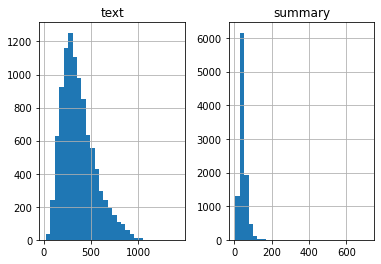

In [ ]:
length_df.hist(bins = 30)
plt.show()

# Model Building


In [ ]:
import numpy as np
import pandas as pd

Installing the dependencies

In [ ]:
X_train, y_train = train_df["cleaned_article"], train_df["cleaned_highlights"]
X_test, y_test = test_df["cleaned_article"], test_df["cleaned_highlights"]
#X_val, y_val = validation_df["cleaned_article"], validation_df["cleaned_highlights"]


#### Prepare Tokenizer
1. Article Tokenizer


In [ ]:
max_len_text = 500

In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
X_train    =   x_tokenizer.texts_to_sequences(X_train)
X_test   =   x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
X_train = pad_sequences(X_train,  maxlen= max_len_text, padding='post')
X_test  = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

2. Highlights Tokenizer


In [ ]:
max_len_highlights = 200

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_train = y_tokenizer.texts_to_sequences(y_train)
y_test =  y_tokenizer.texts_to_sequences(y_test)

#padding zero upto maximum length
y_train = pad_sequences(y_train,  maxlen= max_len_highlights, padding='post')
y_test = pad_sequences(y_test, maxlen=max_len_highlights, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [ ]:
ind=[]
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train =np.delete(y_train,ind, axis=0)
X_train =np.delete(X_train,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test =np.delete(y_test,ind, axis=0)
X_test =np.delete(X_test,ind, axis=0)


#### Model building
1. 3 stacks LSTM for encoder


In [ ]:
from attention import AttentionLayer

In [ ]:
from keras import backend as K
K.clear_session()
latent_dim = 500

# Encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
#decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
#decoder_outputs = decoder_dense(decoder_concat_input)

# Define the output layer
output_text = Dense(units=y_voc_size, activation='softmax')
output = output_text(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 500, 500)     44219000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 500, 500),   2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:] ,epochs=20,callbacks = [es], batch_size= 8, validation_data=([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

Epoch 1/20
1250/1250 [==============================] - 1203s 953ms/step - loss: 1.7709 - val_loss: 1.6706
Epoch 2/20
1250/1250 [==============================] - 1160s 928ms/step - loss: 1.6398 - val_loss: 1.6330
Epoch 3/20
1250/1250 [==============================] - 1160s 928ms/step - loss: 1.5896 - val_loss: 1.6065
Epoch 4/20
1250/1250 [==============================] - 1145s 916ms/step - loss: 1.5459 - val_loss: 1.5942
Epoch 5/20
 850/1250 [===================>..........] - ETA: 5:44 - loss: 1.4933